In [1]:
!pip install pystan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00


In [2]:
import stan
import pandas as pd
import numpy as np
import math
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import nest_asyncio
import arviz as az
nest_asyncio.apply()
import matplotlib.pyplot as plt

In [33]:
# Load data
data = pd.read_csv('/content/sample_data/Foraging_data.csv')

# Convert columns safely
data['Reward'] = pd.to_numeric(data['Reward'], errors='coerce').fillna(0).astype(int)
data['subno'] = pd.to_numeric(data['subno'], errors='coerce').fillna(0).astype(int)
data['Patch'] = pd.to_numeric(data['Patch'], errors='coerce').fillna(0).astype(int)
data['Patch'] = 1 + data['Patch']

# Verify conversions
assert data['Reward'].dtype == np.int64, "Reward column must be integer type"
assert data['subno'].dtype == np.int64, "subno column must be integer type"

In [34]:
wm_foraging = """
data {
  int<lower=1> N;                   // Number of trials
  int<lower=1> A;                   // Number of actions (foraging options)
  array[N] int<lower=1, upper=A> actions;  // Action chosen on each trial
  array[N] int<lower=0> rewards;    // Reward received on each trial
}

parameters {
  real<lower=0, upper=1> epsilon;   // Forgetting/decay parameter
  real<lower=1, upper=10> capacity; // WM capacity parameter
  real<lower=0, upper=1> w0;        // Initial WM weight
  real<lower=0> beta_wm;            // WM inverse temperature
}

transformed parameters {
  real reward_scale = 200.0;  // Maximum reward value from RL2 model
}

model {
  // Priors (from Collins & Frank 2012)
  epsilon ~ normal(0.1, 0.1);      // Typical decay rate for WM models
  capacity ~ normal(4, 1);         // Human WM capacity ~4±1 items[2]
  w0 ~ normal(0.95, 1);            // Initial WM weight bias
  beta_wm ~ normal(12, 3);         // Typical inverse temperature for choice rules

  // Initialize WM values for each action
  vector[A] Q_wm = rep_vector(0.0, A);

  for (t in 1:N) {
    int a = actions[t];

    // Apply decay to WM values (toward uniform)
    for (act in 1:A) {
      Q_wm[act] = Q_wm[act] + epsilon * ((1.0 / A) - Q_wm[act]);
    }

    // Capacity limitation - assumes all options are available each trial
    real p_in_wm = fmin(1.0, capacity / A);  // Use total actions as set size[2]

    // Compute effective WM contribution
    real effective_w = w0 * p_in_wm;

    // Compute choice probabilities (softmax with exploration)
    vector[A] choice_probs;
    vector[A] wm_probs = softmax(beta_wm * Q_wm);

    for (j in 1:A) {
      // Mixture of WM-guided and random exploration[2]
      choice_probs[j] = effective_w * wm_probs[j] +
                       (1 - effective_w) * (1.0 / A);
    }

    // Action selection
    actions[t] ~ categorical(choice_probs);

    // Update WM based on reward (normalized by max reward scale)[2]
    Q_wm[a] = rewards[t] / reward_scale;  // Direct value storage in WM
  }
}

"""

In [35]:
import arviz as az
import matplotlib.pyplot as plt


def plot_mcmc_convergence(fit_object, var_names=['epsilon', 'capacity', 'w0', 'beta_wm'], subject_id=None, block_id=None):
    """
    Generates MCMC trace plots matching the example image style.

    Args:
        fit_object: The fit object returned by compiled_model.sample().
        var_names (list, optional): List of parameter names to plot/summarize.
                                    Defaults to ['alpha', 'beta'].
        subject_id (optional): Identifier for the subject for plot titles.
        block_id (optional): Identifier for the block for plot titles.
    """
    if fit_object is None:
        print("Cannot plot convergence: fit_object is None.")
        return

    # Convert to InferenceData if not already
    if not isinstance(fit_object, az.InferenceData):
        try:
            fit_object = az.convert_to_inference_data(fit_object)
        except Exception as e:
            print(f"Error converting to InferenceData: {e}")
            return

    # Create figure with subplots - one for each parameter
    n_params = len(var_names)
    fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4), sharey=False)

    # Handle single parameter case
    if n_params == 1:
        axes = [axes]

    # Define chain colors matching the example image
    chain_colors = ['#FF7F0E', '#9467BD', '#4C2889', '#DBAF57']  # orange, purple, dark purple, light brown

    # Plot each parameter
    for i, var_name in enumerate(var_names):
        if var_name not in fit_object.posterior:
            print(f"Warning: Parameter '{var_name}' not found in fit object.")
            axes[i].text(0.5, 0.5, f"Parameter '{var_name}' not found",
                        ha='center', transform=axes[i].transAxes)
            continue

        # Get parameter data
        param_data = fit_object.posterior[var_name]

        # Handle multidimensional parameters if needed
        if len(param_data.dims) > 2:
            # For multidimensional params, just plot the first element
            if 'chain' in param_data.dims and 'draw' in param_data.dims:
                flat_dims = [d for d in param_data.dims if d not in ['chain', 'draw']]
                if flat_dims:
                    idx = {dim: 0 for dim in flat_dims}
                    param_data = param_data.isel(**idx)
            else:
                print(f"Warning: Parameter '{var_name}' doesn't have expected dimensions.")
                continue

        # Plot each chain
        for c in range(min(len(param_data.chain), 4)):
            chain_data = param_data.sel(chain=c)
            axes[i].plot(chain_data, color=chain_colors[c], linewidth=0.7, alpha=0.9)

        # Set title and labels
        axes[i].set_title(var_name)
        axes[i].set_xlabel("Iteration")

    # Add legend for chain colors
    handles = [plt.Line2D([0], [0], color=color, linewidth=1)
              for color in chain_colors[:min(len(fit_object.posterior.chain), 4)]]
    labels = [str(i+1) for i in range(min(len(fit_object.posterior.chain), 4))]

    # Place legend with "chain" title like in example
    fig.legend(handles, labels, title="chain",
              loc='upper right', bbox_to_anchor=(0.99, 0.99))

    # Set title if subject/block provided
    if subject_id is not None or block_id is not None:
        title = "MCMC Convergence"
        if subject_id is not None:
            title += f" for Subject {subject_id}"
        if block_id is not None:
            if subject_id is not None:
                title += f", Block {block_id}"
            else:
                title += f" for Block {block_id}"
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()

    # Calculate and print summary statistics
    try:
        print("\nCalculating Summary Statistics (including R-hat, ESS)...")
        summary_stats = az.summary(fit_object, var_names=var_names)
        print("Summary Statistics:")
        with pd.option_context('display.max_rows', None,
                             'display.max_columns', None,
                             'display.width', 1000):
            print(summary_stats)
    except Exception as e:
        print(f"Error generating summary statistics: {e}")


In [36]:
def fit_wm_foraging_model(df, num_chains=4, num_samples=2000):
    all_samples = []
    subject_groups = df.groupby(['subno'])
  #     data {
  #   int<lower=1> N;                   // Number of trials
  #   int<lower=1> A;                   // Number of actions (foraging options)
  #   array[N] int<lower=1, upper=A> actions;  // Action chosen on each trial
  #   array[N] int<lower=0> rewards;    // Reward received on each trial
  # }
    for subject, group_data in subject_groups:
        print(f"Processing Subject: {subject}")
        stan_data = {
            'N': len(group_data),
            'A': 8,
            'actions': group_data['Patch'].values.astype(int),
            'rewards': group_data['Reward'].values.astype(int),
        }
        wm_foraging_sm = stan.build(wm_foraging, data=stan_data)
        rl_fit = wm_foraging_sm.sample(
            num_chains=num_chains,
            num_samples=num_samples
        )
        plot_mcmc_convergence(
            fit_object=rl_fit,
            subject_id=subject,
        )
        epsilon = np.ravel(rl_fit['epsilon'])  # flatten to 1D
        capacity = np.ravel(rl_fit['capacity'])    # flatten to 1D
        w_0 = np.ravel(rl_fit['w0'])
        beta_wm = np.ravel(rl_fit['beta_wm'])

        n_samples = len(w_0)
        samples_df = pd.DataFrame({
            'subno': [subject] * n_samples,
            'epsilon': epsilon,
            'capacity': capacity,
            'w0' : w_0,
            'beta_wm': beta_wm
        })
        all_samples.append(samples_df)
    return pd.concat(all_samples, ignore_index=True)

Processing Subject: (1,)
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_hfvmoros/model_owkrpgzy.stan', line 25, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   1% (101/20000)
Sampling:  

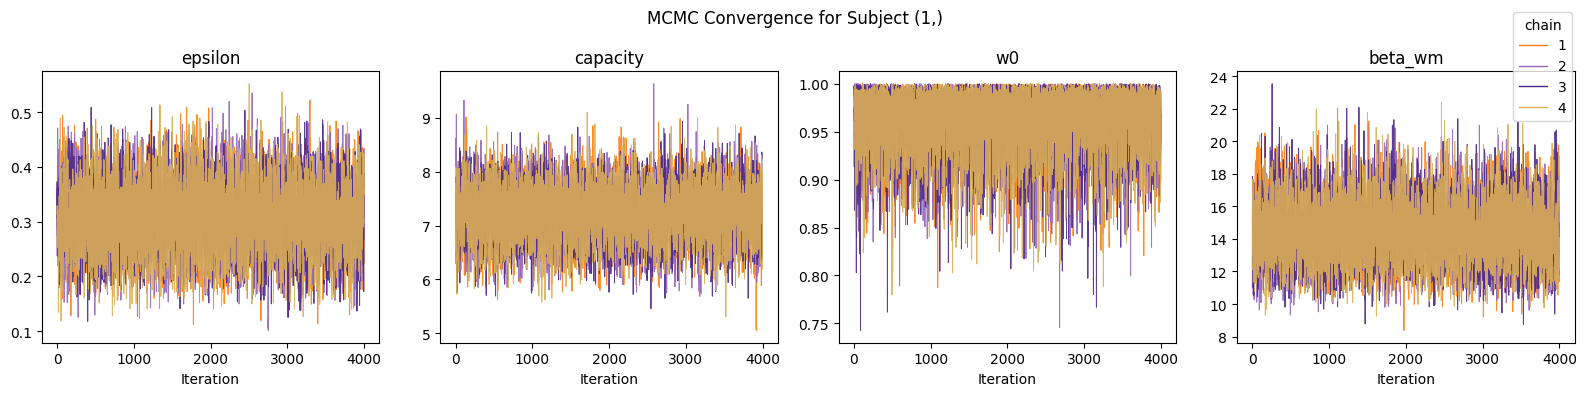


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.306  0.063   0.189    0.422      0.001    0.000    9489.0    9638.0    1.0
capacity   7.256  0.510   6.283    8.168      0.005    0.004   10231.0    8662.0    1.0
w0         0.964  0.032   0.906    1.000      0.000    0.000   10398.0    6627.0    1.0
beta_wm   14.398  1.878  10.907   17.856      0.019    0.015    9365.0   10542.0    1.0


In [37]:
data = data[data['subno']==1]
results_df = fit_wm_foraging_model(data,4,4000)

In [38]:
results_df

,subno,epsilon,capacity,w0,beta_wm
0,"(1,)",0.307052,6.613688,0.983717,12.546431
1,"(1,)",0.320641,7.715262,0.981611,14.885629
2,"(1,)",0.237817,6.941748,0.989052,11.026860
3,"(1,)",0.313745,7.208482,0.992737,15.958294
4,"(1,)",0.330840,6.293732,0.968179,13.228124
...,...,...,...,...,...
15995,"(1,)",0.413325,7.579767,0.969466,16.957423
15996,"(1,)",0.377561,7.540891,0.899443,18.032032
15997,"(1,)",0.266375,7.537246,0.973004,11.841316
15998,"(1,)",0.306262,7.042385,0.965834,14.063927


In [39]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import math

# Extract WM parameters from results
epsilon = results_df['epsilon']
capacity = results_df['capacity']
w0 = results_df['w0']
beta_wm = results_df['beta_wm']

# Prepare 4D parameter samples
samples = np.vstack([epsilon, capacity, w0, beta_wm])

# Perform Kernel Density Estimation
print("Performing 4D Kernel Density Estimation...")
kde = gaussian_kde(samples)
print("KDE calculation finished.")

# WM parameter bounds based on Stan model constraints
param_bounds = [
    (0.0, 1.0),     # epsilon
    (1.0, 10.0),    # capacity
    (0.0, 1.0),     # w0
    (0.1, 30.0)     # beta_wm
]

def neg_kde(params):
    eps, cap, w, beta = params
    # Check parameter bounds
    if not (param_bounds[0][0] <= eps <= param_bounds[0][1] and
            param_bounds[1][0] <= cap <= param_bounds[1][1] and
            param_bounds[2][0] <= w <= param_bounds[2][1] and
            param_bounds[3][0] <= beta <= param_bounds[3][1]):
        return np.inf
    try:
        density = kde(params)[0]
        return -density if (math.isfinite(density) and density > 0) else np.inf
    except Exception:
        return np.inf

store = []

# Increased optimization runs for 4D space
for i in range(1000):
    # Random initial guesses within bounds
    initial_guess = [
        np.random.uniform(low, high)
        for (low, high) in param_bounds
    ]

    print(f"Run {i+1}: Initial params - "
          f"ε={initial_guess[0]:.4f}, C={initial_guess[1]:.4f}, "
          f"w0={initial_guess[2]:.4f}, β={initial_guess[3]:.4f}")

    result = minimize(
        fun=neg_kde,
        x0=initial_guess,
        method='L-BFGS-B',
        bounds=param_bounds,
        options={'ftol': 1e-5, 'gtol': 1e-5, 'disp': False}
    )

    if result.success:
        mle_estimate = result.x
        final_density = kde(mle_estimate)[0]
        store.append([*mle_estimate, final_density])
        print(f"  ε: {mle_estimate[0]:.6f}, C: {mle_estimate[1]:.6f}, "
              f"w0: {mle_estimate[2]:.6f}, β: {mle_estimate[3]:.6f}, "
              f"Density: {final_density:.4g}")
    else:
        print(f"  Optimization failed: {result.message}")

# Create results dataframe
store_results = pd.DataFrame(
    store,
    columns=['epsilon', 'capacity', 'w0', 'beta_wm', 'density']
)


Performing 4D Kernel Density Estimation...
KDE calculation finished.
Run 1: Initial params - ε=0.1841, C=8.2551, w0=0.0038, β=28.5143
  Optimization failed: ABNORMAL: 
Run 2: Initial params - ε=0.8902, C=9.7141, w0=0.4884, β=21.4184
  Optimization failed: ABNORMAL: 
Run 3: Initial params - ε=0.2050, C=6.1941, w0=0.6728, β=6.0609
  ε: 0.204988, C: 6.194066, w0: 0.672756, β: 6.060901, Density: 7.76e-152
Run 4: Initial params - ε=0.0119, C=8.5866, w0=0.1514, β=4.1837
  Optimization failed: ABNORMAL: 
Run 5: Initial params - ε=0.9632, C=4.1760, w0=0.6352, β=16.8623
  Optimization failed: ABNORMAL: 
Run 6: Initial params - ε=0.1646, C=8.0396, w0=0.8608, β=1.8292
  ε: 0.164584, C: 8.039622, w0: 0.860822, β: 1.829238, Density: 2.004e-67
Run 7: Initial params - ε=0.4637, C=6.4967, w0=0.2396, β=3.3692
  Optimization failed: ABNORMAL: 
Run 8: Initial params - ε=0.0534, C=4.0056, w0=0.3129, β=4.7682
  Optimization failed: ABNORMAL: 
Run 9: Initial params - ε=0.4176, C=1.3668, w0=0.3736, β=4.0626


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  Optimization failed: ABNORMAL: 
Run 15: Initial params - ε=0.0535, C=7.5772, w0=0.6859, β=4.5661
  ε: 0.053507, C: 7.577188, w0: 0.685894, β: 4.566133, Density: 3.854e-96
Run 16: Initial params - ε=0.1867, C=7.6626, w0=0.0341, β=18.0956
  Optimization failed: ABNORMAL: 
Run 17: Initial params - ε=0.9234, C=5.5636, w0=0.8655, β=14.1871
  Optimization failed: ABNORMAL: 
Run 18: Initial params - ε=0.3730, C=4.5618, w0=0.3096, β=21.2395
  Optimization failed: ABNORMAL: 
Run 19: Initial params - ε=0.5129, C=8.1683, w0=0.3035, β=20.2684
  Optimization failed: ABNORMAL: 
Run 20: Initial params - ε=0.0330, C=8.2508, w0=0.9282, β=21.2682
  ε: 0.032988, C: 8.250847, w0: 0.928231, β: 21.268246, Density: 5.14e-111
Run 21: Initial params - ε=0.6649, C=2.9498, w0=0.2710, β=1.3454
  Optimization failed: ABNORMAL: 
Run 22: Initial params - ε=0.5166, C=9.0154, w0=0.1376, β=24.9133
  Optimization failed: ABNORMAL: 
Run 23: Initial params - ε=0.0380, C=4.3770, w0=0.6509, β=16.0327
  ε: 0.038043, C: 4.3

In [40]:
rounded_density = store_results['density'].round(1)
# Filter rows with max density and compute mean once
mle_mean = store_results[rounded_density == rounded_density.max()].mean()

# Build MLE estimate dictionary
mle_estimate = {
    'epsilon':  mle_mean['epsilon'],
    'capacity': mle_mean['capacity'],
    'w0':       mle_mean['w0'],
    'beta_wm':  mle_mean['beta_wm']
}

# Access w0 if needed
print(mle_estimate['w0'])


0.9865813705406573


In [41]:
# Count occurrences of each rounded density value
rounded_density.value_counts()

,count
density,
0.0,323
23.7,3
0.1,3
0.3,1
0.2,1
5.8,1
6.7,1


In [43]:
def calculate_wm_log_likelihood(actions, rewards, epsilon, capacity, w0, beta_wm,
                               reward_scale=200.0, num_actions=8):
    """
    Calculate log-likelihood for the working memory foraging model.

    Args:
        actions: Array of chosen actions (0-indexed)
        rewards: Array of received rewards
        epsilon: Forgetting rate parameter (0-1)
        capacity: WM capacity parameter (1-10)
        w0: Initial WM weight (0-1)
        beta_wm: WM inverse temperature (>0)
        reward_scale: Reward normalization factor
        num_actions: Total number of possible actions

    Returns:
        Total log-likelihood for the sequence
    """
    Q_wm = np.zeros(num_actions)  # Initialize WM values
    total_loglik = 0.0

    for t in range(len(actions)):
        a = actions[t]

        # Apply decay to WM values
        Q_wm += epsilon * (1/num_actions - Q_wm)

        # Capacity limitation calculation
        p_in_wm = min(capacity / num_actions, 1.0)
        effective_w = w0 * p_in_wm

        # Compute choice probabilities
        wm_probs = np.exp(beta_wm * Q_wm - np.max(beta_wm * Q_wm))
        wm_probs /= np.sum(wm_probs)

        choice_probs = effective_w * wm_probs + (1 - effective_w) * (1/num_actions)

        # Add log probability with numerical stability
        epsilon_log = 1e-10
        total_loglik += np.log(choice_probs[a] + epsilon_log)

        # Update WM value for chosen action
        normalized_reward = rewards[t] / reward_scale
        Q_wm[a] = normalized_reward  # Direct update per WM model

    return total_loglik

def calculate_aic(log_likelihood, num_params):
    """Calculate Akaike Information Criterion"""
    return 2 * num_params - 2 * log_likelihood

# --- User Input ---
# MLE parameters from WM model fitting
mle_epsilon = mle_estimate['epsilon']    # Example value from Collins & Frank (2012)
mle_capacity = mle_estimate['capacity']    # Typical human WM capacity
mle_w0 = mle_estimate['w0']         # Initial WM weight
mle_beta_wm = mle_estimate['beta_wm']    # Inverse temperature

# Number of estimated parameters (epsilon, capacity, w0, beta_wm)
num_params = 4

# Load and preprocess data
data = pd.read_csv('/content/sample_data/Foraging_data.csv')
data['Reward'] = pd.to_numeric(data['Reward'], errors='coerce').fillna(0).astype(int)
data['subno'] = pd.to_numeric(data['subno'], errors='coerce').fillna(0).astype(int)
data['Patch'] = pd.to_numeric(data['Patch'], errors='coerce').fillna(0).astype(int)

# --- Calculation ---
subjects = data['subno'].unique()
total_ll = 0.0

print(f"Calculating WM model log-likelihood with parameters:")
print(f"ε={mle_epsilon}, C={mle_capacity}, w0={mle_w0}, β_wm={mle_beta_wm}")
sub_data = data[data['subno'] == 1]
actions = sub_data['Patch'].values
rewards = sub_data['Reward'].values
ll = calculate_wm_log_likelihood(actions, rewards, mle_epsilon, mle_capacity,
                                mle_w0, mle_beta_wm)
total_ll += ll
print(f"Subject {1}: LL = {ll:.2f}")

# Calculate AIC
aic_score = calculate_aic(total_ll, num_params)

print(f"\nTotal log-likelihood: {total_ll:.2f}")
print(f"AIC score: {aic_score:.1f} (k={num_params})")


Calculating WM model log-likelihood with parameters:
ε=0.30179676404857697, C=7.221646501634662, w0=0.9865813705406573, β_wm=13.837736901188881
Subject 1: LL = -131.88

Total log-likelihood: -131.88
AIC score: 271.8 (k=4)


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def simulate_wm_behavior(data, mle_params, subject_id, A=8, reward_scale=200.0):
    """
    Simulate the Working Memory foraging model on a subject's data.
    Returns model choices, probabilities, and performance metrics.
    """
    subj_data = data[data['subno'] == subject_id].copy()
    if subj_data.empty:
        print(f"No data found for subject {subject_id} in simulation.")
        return None, None, None

    actions_subj = subj_data['Patch'].values  # 0-indexed patch choices
    rewards_subj = subj_data['Reward'].values
    N = len(actions_subj)

    # Extract WM parameters
    epsilon = mle_params['epsilon']
    capacity = mle_params['capacity']
    w0 = mle_params['w0']
    beta_wm = mle_params['beta_wm']

    print(f"\nSimulating WM Model for Subject {subject_id} (N={N}, A={A}) with parameters:")
    print(f"  ε: {epsilon:.4f}, C: {capacity:.2f}, w0: {w0:.4f}, β_wm: {beta_wm:.4f}")

    # Initialize WM values and storage
    Q_wm = np.zeros(A)
    model_choices = np.zeros(N, dtype=int)
    all_model_probs = np.zeros((N, A))
    memory_contributions = np.zeros(N)

    for t in range(N):
        # Apply decay to WM values
        Q_wm += epsilon * (1/A - Q_wm)

        # Calculate capacity-limited probability
        p_in_wm = min(1.0, capacity / A)
        effective_w = w0 * p_in_wm
        memory_contributions[t] = effective_w

        # Compute choice probabilities
        wm_logits = beta_wm * Q_wm
        wm_logits -= np.max(wm_logits)  # Numerical stability
        wm_probs = np.exp(wm_logits) / np.sum(np.exp(wm_logits))

        # Mix WM and random exploration
        choice_probs = effective_w * wm_probs + (1 - effective_w) * (1/A)
        all_model_probs[t, :] = choice_probs

        # Model choice (most probable patch)
        model_choice = np.argmax(choice_probs)
        model_choices[t] = model_choice

        # Update WM based on subject's actual choice
        subject_choice = actions_subj[t]
        normalized_reward = rewards_subj[t] / reward_scale
        Q_wm[subject_choice] = normalized_reward  # Direct WM update

    # Performance metrics
    accuracy = np.mean(actions_subj == model_choices)
    total_reward_subject = np.sum(rewards_subj)

    # Plotting
    plt.figure(figsize=(14, 5))
    plt.plot(range(N), actions_subj, 'o-', label='Subject Choices', alpha=0.7)
    plt.plot(range(N), model_choices, 'x-', label='WM Model Choices', alpha=0.7)
    plt.plot(range(N), memory_contributions, '--', label='WM Contribution', color='purple')
    plt.yticks(range(A), [f'Patch {i}' for i in range(A)])
    plt.xlabel('Trial')
    plt.ylabel('Patch Chosen')
    plt.title(f'WM Model Simulation: Subject {subject_id}\n(ε={epsilon:.2f}, C={capacity:.1f}, w0={w0:.2f}, β_wm={beta_wm:.1f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    os.makedirs('plots', exist_ok=True)
    plot_filename = f"plots/simulation_wm_subj_{subject_id}.png"
    plt.savefig(plot_filename, dpi=150)
    print(f"✅ Saved WM simulation plot to {plot_filename}")
    plt.close()

    # Print metrics
    print(f"\nWM Model Performance for Subject {subject_id}:")
    print(f"  Total subject reward: {total_reward_subject}")
    print(f"  Choice accuracy: {accuracy:.3f}")
    print(f"  Avg WM contribution: {np.mean(memory_contributions):.3f}")

    # Return simulation results
    timeseries_data = {
        'model_choices': model_choices,
        'subject_choices': actions_subj,
        'memory_contributions': memory_contributions,
        'model_probs': all_model_probs,
        'Q_wm_history': Q_wm.copy()
    }
    return model_choices, all_model_probs, timeseries_data


simulate_wm_behavior(data, mle_estimate, subject_id=1, A=8)



Simulating WM Model for Subject 1 (N=137, A=8) with parameters:
  ε: 0.3018, C: 7.22, w0: 0.9866, β_wm: 13.8377
✅ Saved WM simulation plot to plots/simulation_wm_subj_1.png

WM Model Performance for Subject 1:
  Total subject reward: 14872
  Choice accuracy: 0.752
  Avg WM contribution: 0.891


(array([0, 0, 0, 0, 3, 4, 4, 6, 6, 6, 6, 3, 3, 6, 6, 6, 6, 3, 4, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 3, 3, 3, 3,
        3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3,
        4, 4, 4, 4, 0]),
 array([[0.125     , 0.125     , 0.125     , ..., 0.125     , 0.125     ,
         0.125     ],
        [0.62458874, 0.05363018, 0.05363018, ..., 0.05363018, 0.05363018,
         0.05363018],
        [0.46485972, 0.04986522, 0.08087918, ..., 0.08087918, 0.08087918,
         0.08087918],
        ...,
        [0.01713798, 0.01713775, 0.01713775, ..., 0.01713775, 0.01813874,
         0.01713775],
        [0.02983107, 0.02983032, 0.02983032, ..., 0.02983032, 0.03296471,
         0.01850423],
        [0.76941449, 0.02000544, 0.020